<a href="https://colab.research.google.com/github/rodrigoviannini/Machine-Learning/blob/main/Aula_16_redu%C3%A7%C3%A3o_de_dimensionalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 16 - redução de dimensionalidade

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) PCA
- 2) PCA na Pipeline
- 3) A matemática do PCA


In [ ]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

____
____
_____

## 1) PCA

PCA (principal component analysis) é uma técnica **não supervisionada** que determina **as direções de máxima variância** no espaço de features, de modo que **as direções são ortogonais entre si**.

Ou seja,

> A primeira componente principal é a direção que maximiza a variáncia dos dados projetados em sua direção; A segunda componente principal é uma direção ortogonal à primeira que também maximiza a variância nesta direção, e assim sucessivamente.

<img src=https://austingwalters.com/wp-content/uploads/2014/11/gaussDist-labeled.png width=400>

É importante lembrar que:

- Se o espaço original tem $n$ features, é possível construir $n$ componentes principais;<br><br>
- Cada componente principal é uma **combinação linear das features originais**;<br><br>
- As componentes principais são ortogonais entre si;<br><br>
- As componentes principais são linearmente descorrelacionadas;<br>

É muito comum que PCA seja utilizada como uma técnica de **redução de dimensionalidade**, isto porque, **no espaço transformado de componentes principais**, é comum que grande parte da variância completa dos dados esteja contida nas $L$ primeiras componentes principais ($L < n$).

Sendo assim, ao invés de utilizar o espaço de features completo (de dimensão $n$) para a construção de modelos, podemos utilizar apenas $L$ dimensões **do espaço de features de componentes principais**, reduzindo, assim, a dimensionalidade do espaço de features efetivo em que os estimadores irão trabalhar.

Os objetivos desta redução podem ser:

- Evitar a maldição da dimensionalidade;
- Treinar modelos mais rápido (de maneira mais eficiente), afinal, há menos dados;
- Fornecer dados sem qualquer colinearidade (há estimadores que assumem não-colinearidade!)

### 1.1) O que é cada PC?

Como dissemos acima, cada componente principal é uma **combinação linear das features originais**.

Nesse sentido, podemos enxergar o PCA como um método que constrói um novo espaço de features, de mesma dimensão que o espaço original:

<img src=https://miro.medium.com/max/1200/1*V3JWBvxB92Uo116Bpxa3Tw.png width=700>

O ponto é que o espaço de features construído pelo PCA é muito particular: as novas features são ortogonais entre si, e tais que maximizam a variância dos dados em cada sub-espaço de projeção, como dissemos acima.

Assim, na prática, seja um espaço de input $\mathcal{X}$ de $n$ dimensões, tal que cada vetor de features $\vec{x} \in \mathcal{X}$ é dado por:

$ \vec{x} = \left ( x_1, x_2, x_3, \cdots , x_n \right) $

Após a aplicação do PCA, estaremos no espaço de componentes principais, tal que um vetor de features neste espaço, $\vec{x}_{PC}$, será dado por:

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, \cdots , PC_n \right) $

Onde cada componente principal é uma combinação linear das features originais, isto é, 

$ PC_i = \sum_{k=1}^n \alpha_{i, k} x_k = \alpha_{i, 1} x_1 +  \alpha_{i, 2} x_2 + \cdots +  \alpha_{i, n} x_n$

Note que cada componente principal $i$ tem $n$ coeficientes diferentes $\alpha_{i, k}$, que acompanham cada uma das features $k$ do espaço original.

Para entender melhor, vamos tomar um dataset bem simples!

In [ ]:
df = pd.read_csv("../datasets/iris.csv")

In [ ]:
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
X = df.drop(columns="species")
y = df["species"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [ ]:
X_train

,sepal_length,sepal_width,petal_length,petal_width
8,4.4,2.9,1.4,0.2
106,4.9,2.5,4.5,1.7
76,6.8,2.8,4.8,1.4
9,4.9,3.1,1.5,0.1
89,5.5,2.5,4.0,1.3
...,...,...,...,...
37,4.9,3.6,1.4,0.1
2,4.7,3.2,1.3,0.2
33,5.5,4.2,1.4,0.2
52,6.9,3.1,4.9,1.5


No caso do dataset iris, temos 4 features, de modo que o espaço original tem 4 dimensões, e um vetor de features é:

$ \vec{x} = (x_1, x_2, x_3, x_4)$.

Sendo que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Assim, esperamos que após o PCA, o espaço de componentes principais também tenha 4 dimensões, isto é, 

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, PC_4 \right) $

E as componentes principais serão: 

$ PC_1 = \alpha_{1, 1} x_1 + \alpha_{1, 2} x_2 + \alpha_{1, 3} x_3 + \alpha_{1, 4} x_4$

$ PC_2 = \alpha_{2, 1} x_1 + \alpha_{2, 2} x_2 + \alpha_{2, 3} x_3 + \alpha_{2, 4} x_4$

$ PC_3 = \alpha_{3, 1} x_1 + \alpha_{3, 2} x_2 + \alpha_{3, 3} x_3 + \alpha_{3, 4} x_4$

$ PC_4 = \alpha_{4, 1} x_1 + \alpha_{4, 2} x_2 + \alpha_{4, 3} x_3 + \alpha_{4, 4} x_4$

Vamos agora aplicar o PCA para calcular as componentes principais!

Mas antes, um ponto muito importante: **devemos escalar as features originais com o StandardScaler antes de aplicarmos o PCA**!

Isso porque o método matemático recebe dados com média 0 e desvio padrão 1!

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(X_train)

X_train_ss = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)

X_train_ss

,sepal_length,sepal_width,petal_length,petal_width
0,-1.721568,-0.332101,-1.345722,-1.323276
1,-1.124492,-1.227655,0.414505,0.651763
2,1.144395,-0.555990,0.584850,0.256755
3,-1.124492,0.115676,-1.288941,-1.454945
4,-0.408002,-1.227655,0.130598,0.125086
...,...,...,...,...
115,-1.124492,1.235118,-1.345722,-1.454945
116,-1.363322,0.339564,-1.402504,-1.323276
117,-0.408002,2.578448,-1.345722,-1.323276
118,1.263810,0.115676,0.641631,0.388424


Agora sim!

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42).fit(X_train_ss)

Com o PCA fitado, temos alguns atributos importantes!

In [ ]:
pca.feature_names_in_

array(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
      dtype=object)

In [ ]:
pca.components_

array([[ 0.52679335, -0.25307206,  0.58186918,  0.56557189],
       [ 0.34813945,  0.93470791,  0.02689438,  0.06630793],
       [-0.72745724,  0.22196252,  0.1386138 ,  0.6342908 ],
       [ 0.26850263, -0.11405393, -0.80093144,  0.52288323]])

In [ ]:
pca.n_components_

4

O atributo `components_` dá exatamente os coeficientes $\alpha_{i, k}$ que determinan as combinações lineares de cada componente principal!

In [ ]:
for j in range(pca.n_components_):
    
    string = (f'PC_{j+1} = ' 
              + 
              " + ".join([f"({alpha:.3f})*x_{i+1}" for i, alpha in enumerate(pca.components_[j])])
              +
              "\n")
    
    print(string)

PC_1 = (0.527)*x_1 + (-0.253)*x_2 + (0.582)*x_3 + (0.566)*x_4

PC_2 = (0.348)*x_1 + (0.935)*x_2 + (0.027)*x_3 + (0.066)*x_4

PC_3 = (-0.727)*x_1 + (0.222)*x_2 + (0.139)*x_3 + (0.634)*x_4

PC_4 = (0.269)*x_1 + (-0.114)*x_2 + (-0.801)*x_3 + (0.523)*x_4



Ou seja,

$PC_1 = 0.527x_1 -0.253x_2 + 0.582x_3 + 0.566x_4$

$PC_2 = 0.348x_1 + 0.935x_2 + 0.027x_3 + 0.066x_4$

$PC_3 = -0.727x_1 + 0.222x_2 + 0.139x_3 + 0.634x_4$

$PC_4 = 0.269x_1 -0.114x_2 -0.801x_3 + 0.523x_4$

Lembrando que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Há alguns outros atributos muito importantes:

In [ ]:
X_train_ss.std().sum()

4.016771562027472

In [ ]:
pca.explained_variance_

array([2.93151868, 0.93042018, 0.15254729, 0.01912729])

In [ ]:
pca.explained_variance_ratio_*100

array([72.67723405, 23.06666702,  3.78190145,  0.47419749])

In [ ]:
pca.explained_variance_ratio_.cumsum()*100

array([ 72.67723405,  95.74390107,  99.52580251, 100.        ])

Podemos plotar os resultados acima:

In [ ]:
labels = [f"PC_{i+1}" for i in range(pca.n_components_)]

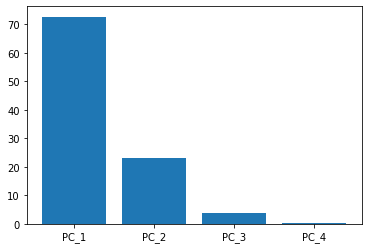

In [ ]:
plt.bar(labels, pca.explained_variance_ratio_*100);

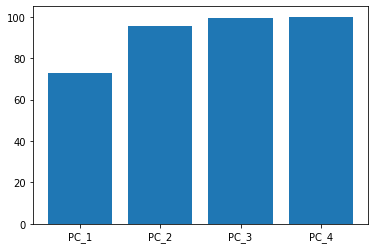

In [ ]:
plt.bar(labels, pca.explained_variance_ratio_.cumsum()*100);

Dos resultados, é fácil ver que com apenas 2 componentes principais, capturamos 95% da variância dos dados!

Assim, caso queiramos reduzir o número de dimensões de $n=4$ para $L=2$, temos a garantia de que grande parte da variabilidade estará contida nas duas componentes principais que usaremos para modelagem!

> Veja que a escolha de $L < n$ componentes principais pode ser visto como um procedimento de **feature selection**, mas feito **no espaço de componentes principais!**
> Como não são as features originais que são selecionadas, é comum nos referirmos a este procedimento como **redução de dimensionalidade** (e a dimensionalidade que é reduzida é do espaço de componentes principais!)

De fato, note que **todas as 4 features originais** estão presentes em cada uma das PCs, como termos da combinação linear que define cada PC. E, naturalmente, todas as 4 estão presentes nas $L$ primeiras.

Caso queiramos construir modelos no espaço de componentes principais, é importante que incorporemos o PCA em nossa pipeline! 

Vamos ver na prática!

____________

## 2) PCA na Pipeline

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

In [ ]:
df = pd.read_csv("../datasets/iris.csv")

X = df.drop(columns="species")
y = df["species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


Métricas de avaliação de treino:
[[40  0  0]
 [ 0 38  2]
 [ 0  1 39]]


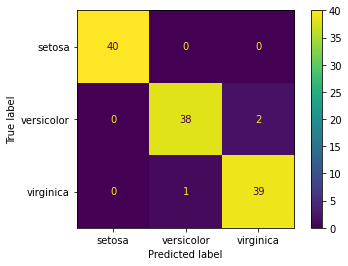

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.95      0.96        40
   virginica       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120


Métricas de avaliação de teste:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


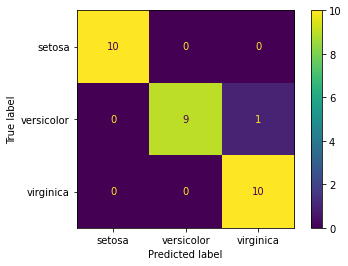

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
pipe_no_pca = Pipeline([("lr", LogisticRegression(random_state=42))])

pipe_no_pca.fit(X_train, y_train)

metricas_classificacao(pipe_no_pca, X_train, X_test, y_train, y_test)


Métricas de avaliação de treino:
[[40  0  0]
 [ 0 35  5]
 [ 0  3 37]]


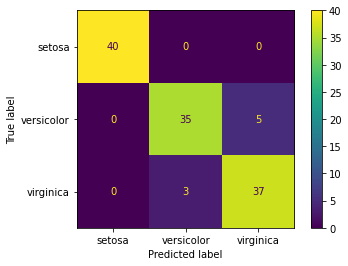

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.92      0.88      0.90        40
   virginica       0.88      0.93      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120


Métricas de avaliação de teste:
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]


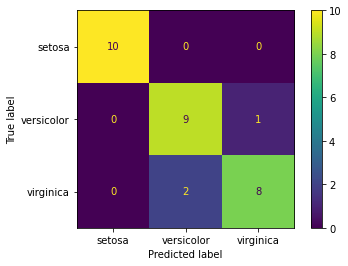

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [ ]:
pipe_pca = Pipeline([("ss", StandardScaler()),
                        # depois da anália prévia acima, vimos que é suficiente considerar 2 PCs
                        ("pca", PCA(n_components=2)),
                        ("lr", LogisticRegression(random_state=42))])

pipe_pca.fit(X_train, y_train)

metricas_classificacao(pipe_pca, X_train, X_test, y_train, y_test)


Métricas de avaliação de treino:
[[40  0  0]
 [ 0 35  5]
 [ 0  3 37]]


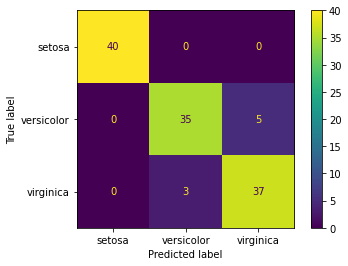

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.92      0.88      0.90        40
   virginica       0.88      0.93      0.90        40

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120


Métricas de avaliação de teste:
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]


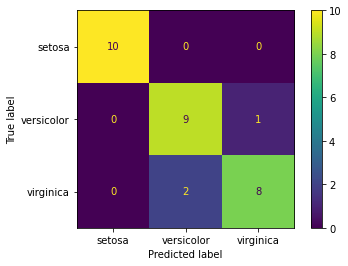

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [ ]:
pipe_pca = Pipeline([("ss", StandardScaler()),
                     # fixando diretamente a variancia explicada desejada
                     ("pca", PCA(n_components=0.9)),
                     ("lr", LogisticRegression(random_state=42))])

pipe_pca.fit(X_train, y_train)

metricas_classificacao(pipe_pca, X_train, X_test, y_train, y_test)

In [ ]:
vars(pipe_pca.steps[1][-1])

{'n_components': 0.9,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 4,
 '_fit_svd_solver': 'full',
 'mean_': array([-1.36927506e-16,  9.99200722e-16,  1.66533454e-17,  1.70234197e-16]),
 'noise_variance_': 0.08583728943622848,
 'n_samples_': 120,
 'n_features_': 4,
 'components_': array([[ 0.52679335, -0.25307206,  0.58186918,  0.56557189],
        [ 0.34813945,  0.93470791,  0.02689438,  0.06630793]]),
 'n_components_': 2,
 'explained_variance_': array([2.93151868, 0.93042018]),
 'explained_variance_ratio_': array([0.72677234, 0.23066667]),
 'singular_values_': array([18.67754597, 10.52235723])}

In [ ]:
pipe_pca.steps[1][-1].n_components_

2

___________

Vamos analisar um outro dataset?

In [ ]:
df_bc = pd.read_csv("../datasets/breast_cancer.csv")

X = df_bc.drop(columns=["id", "diagnosis"])
y = df_bc["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

Antes, vamos analisar o PCA

In [ ]:
ss = StandardScaler().fit(X_train)
X_train_ss = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)

pca_bc = PCA(random_state=42).fit(X_train_ss)

In [ ]:
pca_bc.components_

array([[ 2.17057431e-01,  1.01899728e-01,  2.25804376e-01,
         2.19078681e-01,  1.48588416e-01,  2.41928271e-01,
         2.57761371e-01,  2.60382814e-01,  1.42086256e-01,
         7.15926428e-02,  2.04691204e-01,  2.02094854e-02,
         2.10070529e-01,  1.99926314e-01,  2.31645996e-02,
         1.75338940e-01,  1.50796174e-01,  1.84482732e-01,
         5.03977614e-02,  1.06999631e-01,  2.26607291e-01,
         1.04175660e-01,  2.35493815e-01,  2.23108037e-01,
         1.29967792e-01,  2.10301491e-01,  2.26321939e-01,
         2.49366974e-01,  1.22964478e-01,  1.33513179e-01],
       [-2.39775900e-01, -6.15333635e-02, -2.20948876e-01,
        -2.36925147e-01,  1.77062535e-01,  1.39921191e-01,
         6.00889218e-02, -4.05327434e-02,  1.93611573e-01,
         3.66647802e-01, -1.10269914e-01,  7.58423303e-02,
        -9.44153634e-02, -1.57130070e-01,  1.90534593e-01,
         2.24035281e-01,  2.02018669e-01,  1.33312587e-01,
         1.74132183e-01,  2.76203478e-01, -2.23083155e-

In [ ]:
X_train_ss.std().sum()

30.033021473948068

In [ ]:
pca_bc.explained_variance_

array([1.34075237e+01, 5.57583121e+00, 2.88172583e+00, 1.98248759e+00,
       1.69040102e+00, 1.19918188e+00, 6.65811271e-01, 4.85268216e-01,
       3.86285667e-01, 3.50468676e-01, 3.03174298e-01, 2.72258795e-01,
       2.38314353e-01, 1.44161469e-01, 9.14330565e-02, 7.55558771e-02,
       5.93879845e-02, 5.24392723e-02, 4.73079416e-02, 3.16151650e-02,
       2.99319648e-02, 2.39270335e-02, 2.35728449e-02, 1.59724926e-02,
       1.53896919e-02, 7.94084410e-03, 6.31364827e-03, 1.51324664e-03,
       7.60153510e-04, 1.24064291e-04])

In [ ]:
pca_bc.explained_variance_ratio_*100

array([4.45935222e+01, 1.85452555e+01, 9.58464121e+00, 6.59376825e+00,
       5.62228616e+00, 3.98848772e+00, 2.21449317e+00, 1.61400564e+00,
       1.28478896e+00, 1.16566138e+00, 1.00835994e+00, 9.05534747e-01,
       7.92635285e-01, 4.79482101e-01, 3.04107016e-01, 2.51299401e-01,
       1.97524871e-01, 1.74413404e-01, 1.57346560e-01, 1.05152270e-01,
       9.95539341e-02, 7.95814888e-02, 7.84034550e-02, 5.31246275e-02,
       5.11862282e-02, 2.64113057e-02, 2.09992404e-02, 5.03306942e-03,
       2.52827614e-03, 4.12638742e-04])

In [ ]:
pca_bc.explained_variance_ratio_.cumsum()*100

array([ 44.5935222 ,  63.13877766,  72.72341886,  79.31718711,
        84.93947327,  88.927961  ,  91.14245416,  92.7564598 ,
        94.04124876,  95.20691014,  96.21527008,  97.12080483,
        97.91344011,  98.39292221,  98.69702923,  98.94832863,
        99.1458535 ,  99.32026691,  99.47761347,  99.58276574,
        99.68231967,  99.76190116,  99.84030461,  99.89342924,
        99.94461547,  99.97102678,  99.99202602,  99.99705909,
        99.99958736, 100.        ])

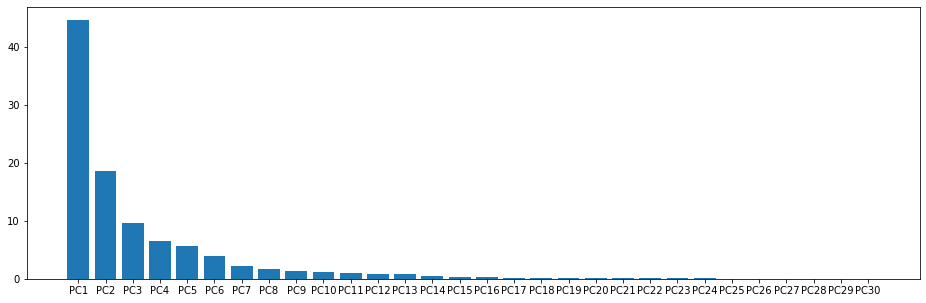

In [ ]:
labels = [f"PC{i+1}" for i in range(pca.n_components_)]

plt.figure(figsize=(16,5))
plt.bar(labels, pca.explained_variance_ratio_*100);

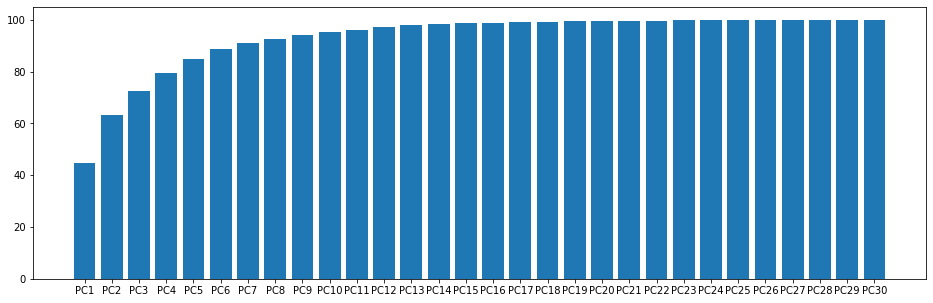

In [ ]:
plt.figure(figsize=(16,5))
plt.bar(labels, pca.explained_variance_ratio_.cumsum()*100);

Vamos treinar modelos!


Métricas de avaliação de treino:
[[285   0]
 [  6 164]]


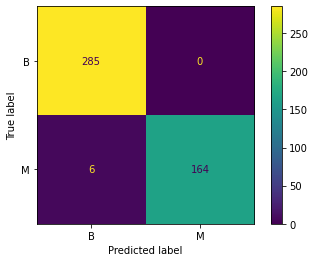

              precision    recall  f1-score   support

           B       0.98      1.00      0.99       285
           M       1.00      0.96      0.98       170

    accuracy                           0.99       455
   macro avg       0.99      0.98      0.99       455
weighted avg       0.99      0.99      0.99       455


Métricas de avaliação de teste:
[[71  1]
 [ 3 39]]


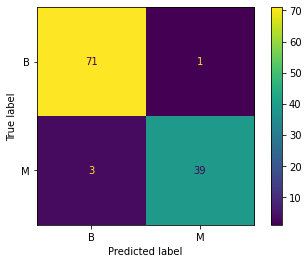

              precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
pipe_no_pca = Pipeline([("ss", StandardScaler()),
                        ("lr", LogisticRegression(random_state=42, max_iter=1000))])

pipe_no_pca.fit(X_train, y_train)

metricas_classificacao(pipe_no_pca, X_train, X_test, y_train, y_test)


Métricas de avaliação de treino:
[[276   9]
 [ 14 156]]


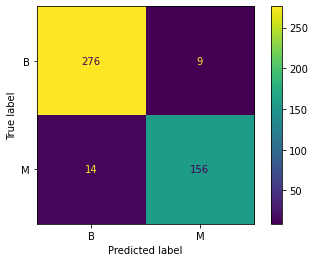

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       285
           M       0.95      0.92      0.93       170

    accuracy                           0.95       455
   macro avg       0.95      0.94      0.95       455
weighted avg       0.95      0.95      0.95       455


Métricas de avaliação de teste:
[[71  1]
 [ 5 37]]


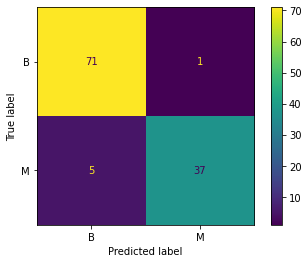

              precision    recall  f1-score   support

           B       0.93      0.99      0.96        72
           M       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



In [ ]:
pipe_pca = Pipeline([("ss", StandardScaler()),
                     ("pca", PCA(n_components=2)),
                     ("lr", LogisticRegression(random_state=42))])

pipe_pca.fit(X_train, y_train)

metricas_classificacao(pipe_pca, X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler


Métricas de avaliação de treino:
[[280   5]
 [ 20 150]]


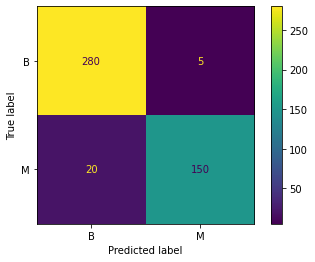

              precision    recall  f1-score   support

           B       0.93      0.98      0.96       285
           M       0.97      0.88      0.92       170

    accuracy                           0.95       455
   macro avg       0.95      0.93      0.94       455
weighted avg       0.95      0.95      0.94       455


Métricas de avaliação de teste:
[[71  1]
 [ 6 36]]


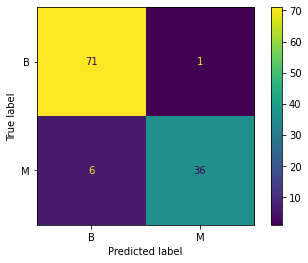

              precision    recall  f1-score   support

           B       0.92      0.99      0.95        72
           M       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



In [ ]:
pipe_pca = Pipeline([("mms", MinMaxScaler()),
                     ("pca", PCA(n_components=2)),
                     ("lr", LogisticRegression(random_state=42))])

pipe_pca.fit(X_train, y_train)

metricas_classificacao(pipe_pca, X_train, X_test, y_train, y_test)

____________

## 3) A matemática do PCA

(Adaptado do notebook do Walisson!)

__________

Considere a matriz de features $X_{N \times n}$

> $N$ linhas (observações), cada uma caracterizada por $n$ features no espaço original.

Cada observação $i$ é caracterizada pelo vetor de features $\vec{x}_i = (x_{i1}, x_{i2}, \cdots, x_{in}$), que são as linhas da matriz de features:

$$
  X = \left [ \begin{array}{ccccc}
x_{11} & x_{12} & x_{13} & \cdots & x_{1n}\\ 
x_{21} & x_{22} & x_{23} & \cdots & x_{2n}\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
x_{N1} & x_{N2} & x_{N3} & \cdots & x_{Nn}\\ 
   \end{array} \right ] 
$$

### Passo 1 - standardização

Para dados em que as features originais $x_j$ estão em escalas diferentes, é necessário escalar os dados para que eles tenham média 0 e desvio padrão 1 (ou seja, usamos o `StandardScaler`). 

Isso porque os componentes são influenciados pela escala das variáveis, justamente porque as matrizes de covariâncias, $\Sigma$ ou $\hat{\Sigma} = S$, são sensíveis à escala de um par de variáveis. 

Considere:

- $\bar{x}_j$ a média da variável $x_j$; 
- $s(x_j)$ o desvio padrão de $x_j$; 

Sendo $i = 1, 2,3,4,\cdots, N$ e $j = 1, 2,3,4,\cdots, n$.

Com isso, a padronização pode ser realizada por meio da equação abaixo: 

- Média 0 e desvio padrão 1: 

$$ \tilde{x}_{ij}= \frac{x_{ij}-\bar{x_j}}{s(X_j)} $$ 

<br>

### Passo 2 - cálculo da matriz de covariância

Calcular a matriz de **covariância**/**correlação**, que são dadas por:

$$
  S = \left [ \begin{array}{ccccc}
\hat{Var}(x_1) & \hat{Cov}(x_1x_2) & \hat{Cov}(x_1x_3) & \cdots & \hat{Cov}(x_1x_n)\\ 
\hat{Cov}(x_2x_1) &\hat{Var}(x_2)& \hat{Cov}(x_2x_3) & \cdots & \hat{Cov}(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
\hat{Cov}(x_nx_1) & \hat{Cov}(x_nx_2)  & \hat{Cov}(x_nx_3)  & \cdots & \hat{Var}(x_n)\\ 
   \end{array} \right ] 
$$

<br>
<br>

$$
  R = \left [ \begin{array}{ccccc}
1 & r(x_1x_2) & r(x_1x_3) & \cdots & r(x_1x_n)\\ 
r(x_2x_1) & 1 & r(x_2x_3) & \cdots & r(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
r(x_nx_1) & r(x_nx_2)  & r(x_nx_3)  & \cdots & 1\\ 
   \end{array} \right ] 
$$

Em que:

$$
 \begin{array}{ccc}
\hat{Var}(x_j) = \frac{\sum_{i=1}^{N}(x_{ij}-\bar{x}_j)}{N-1}, & 
\hat{Cov}(x_{j1},x_{j2}) = \frac{\sum_{i=1}^N(x_{ij1}-\bar{x_{j1}})(x_{ij2}-\bar{x_{j2}})}{N-1}, &
r(x_{j1},x_{j2}) = \frac{\hat{Cov}(x_{j1},x_{j2})}{S_{xj1}S_{xj2}}
   \end{array} 
$$

<br>

### Passo 3 - determinação de autovalores e autovetores

As componentes principais são determinadas através da equação característica (equação de autovalores) da matriz S ou R:

$$det[R - \lambda I]= 0 $$

Em que $I$ é a matriz identidade de dimensão $n \times n $. 

Se R ou S tem posto completo igual a $n$, então $det[R - \lambda I]= 0$, que pode ser reescrito como $\mid R - \lambda I \mid = 0$, terá $n$ soluções. Lembrando que ter posto completo significa que nenhuma coluna é combinação linear de outra.

Considere que $\lambda_1,\lambda_2,\lambda_3, \cdots, \lambda_n$ sejam as raízes da equação característica de R ou S, então temos que  $\lambda_1 > \lambda_2 > \lambda_3 > \cdots, \lambda_n$. 

Chamamos $\lambda_i$ de **autovalores**. 

Além disso, para cada autovalor há um **autovetor** $\tilde{a}_i$ associado, $
  \tilde{a}_i = \left [ \begin{array}{c}
a_{i1}\\ 
a_{i2}\\ 
\vdots \\
a_{ip} \\ 
   \end{array} \right ] 
$

O cálculo do autovetor $\tilde{a}_i$, pode ser realizado considerando a seguinte propriedade:

$$ R\tilde{a}_i =  \lambda_i \tilde{a}_i $$

O autovetor deve ser normalizado, isso é,

$$ a_i = \frac{\tilde{a}_i }{\mid \tilde{a}_i  \mid}$$

Desta maneira, as componentes do vetor são tais que sua norma L2 é igual a 1.

<br>

### Passo 4 - cálculo das componentes principais

O cálculo da i-ésima componente principal é dado por:

$$PC_i = a_{i1}x_1 + a_{i2}x_2 + a_{i3}x_3 + \cdots + a_{in}x_n $$

em que $a_{i1}$ são as componetes do autovetor $a_i$ associado ao autovalor $\lambda_i$.

__________

Operacionalmente, o PCA se apoia em um procedimento matemático denominado **Singular Value Decomposition (SVD)**, que é uma forma de decompor qualquer matriz não quadrada $M_{m\times n}$,

$$M_{m\times n} = U_{m \times m}\Sigma_{m \times n}V_{n \times n}^{\dagger}$$

- onde $U$ é uma matriz unitária $m\times m$ real ou complexa;

- $\Sigma$ é uma matriz retangular diagonal $m\times n$ com números reais não-negativos na diagonal;

- e $V^{\dagger}$ (a conjugada transposta de $V$) é uma matriz unitária $n\times n$ real ou complexa. 

Os valores de $\Sigma$ são os chamados valores singulares de $M$. As $m$ colunas de $U$ e as $n$ colunas de $V$ são os chamados vetores singulares à esquerda e vetores singulares à direita de $A$, respetivamente.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/800px-Singular_value_decomposition_visualisation.svg.png width=300>